In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as distributions
numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)
import data.datasets as datasets
import visualization
import models
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves
import flax.linen as nn
from flax.core import freeze, unfreeze
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from utils import settings

rng_key = jax.random.PRNGKey(0)

In [2]:
rng_key, rng_key_ = jax.random.split(rng_key)
x_a = distributions.Normal(jnp.array([1.0]), jnp.array([0.3])).sample(rng_key_, (512, ))
rng_key, rng_key_ = jax.random.split(rng_key)
x_b = distributions.Normal(jnp.array([2.0]), jnp.array([0.25])).sample(rng_key_, (512, ))
rng_key, rng_key_ = jax.random.split(rng_key)
#x_c = distributions.Normal(jnp.array([4.0]), jnp.array([0.5])).sample(rng_key_, (50, ))
x = jnp.concatenate([x_a, x_b]).squeeze()
print(x.shape)

(1024,)


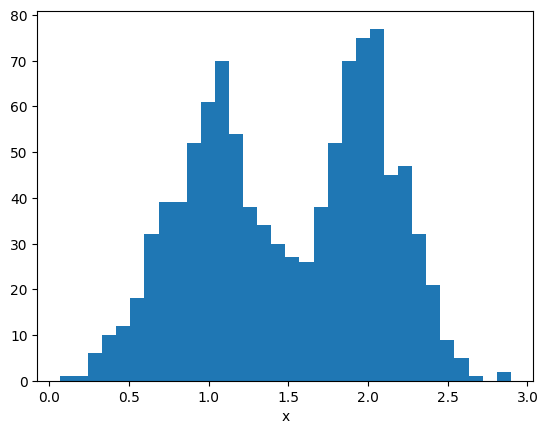

In [3]:
counts, bins = np.histogram(x, bins=32)
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_aspect("auto")
ax.set_xlabel("x")

ax.hist(bins[:-1], bins, weights=counts, color="tab:blue")
figure

In [4]:
k = 2
def model(data):
    weights = numpyro.sample("weights", distributions.Dirichlet(0.5 * jnp.ones(k)))
    
    with numpyro.plate("components", k):
        parameters = numpyro.sample("parameters", distributions.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))
        # TODO: Make scale positive
    
    with numpyro.plate("data", len(data)):
        assignment = numpyro.sample("assignment", distributions.Categorical(weights), infer={"enumerate": "parallel"})
        return numpyro.sample("obs", distributions.Normal(parameters[assignment, 0], parameters[assignment, 1]), obs=data)

In [5]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model).get_trace(x)
print(numpyro.util.format_shapes(trace))

   Trace Shapes:         
    Param Sites:         
   Sample Sites:         
    weights dist      | 2
           value      | 2
components plate    2 |  
 parameters dist    2 | 2
           value    2 | 2
      data plate 1024 |  
 assignment dist 1024 |  
           value 1024 |  
        obs dist 1024 |  
           value 1024 |  


In [68]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(
        kernel,
        num_warmup=128,
        num_samples=32,
        num_chains=128,
        progress_bar=True,
    )

/tmp/ipykernel_545542/2458496529.py:2: UserWarning: There are not enough devices to run parallel chains: expected 128 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(128)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


In [69]:
mcmc.run(rng_key, x)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 632.38it/s, 7 steps of size 1.77e-02. acc. prob=0.94]


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 628.53it/s, 31 steps of size 1.50e-01. acc. prob=0.09]


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 814.17it/s, 11 steps of size 1.78e-02. acc. prob=0.94]


In [70]:
samples = mcmc.get_samples()

In [71]:
print(samples["parameters"].shape)

(4096, 2, 2)


In [72]:
means = samples["parameters"].mean(0)
print(means)

[[1.4148899 0.3133796]
 [1.4543668 0.3376818]]


In [73]:
component_1 = distributions.Normal(means[0, 0], means[0, 1])
component_2 = distributions.Normal(means[1, 0], means[1, 1])

In [74]:
x_lin = jnp.linspace(0.0, 2.7, 128)
y_1 = jnp.exp(component_1.log_prob(x_lin))
y_2 = jnp.exp(component_2.log_prob(x_lin))

y_1 = y_1 / y_1.max()
y_2 = y_2 / y_2.max()

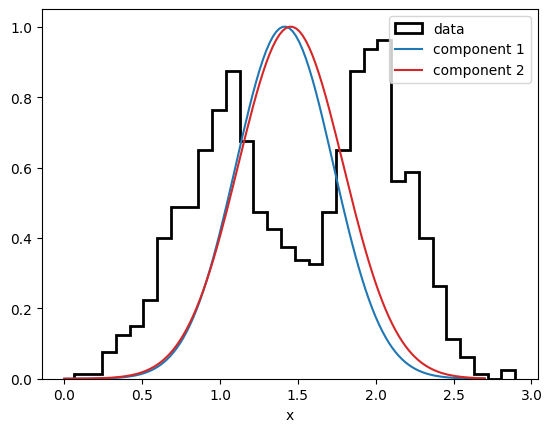

In [75]:
counts, bins = np.histogram(x, bins=32)
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_aspect("auto")
ax.set_xlabel("x")

ax.hist(bins[:-1], bins, weights=counts / 80.0, color="black", histtype="step", linewidth=2, label="data")
ax.plot(x_lin, y_1, color="tab:blue", label="component 1")
ax.plot(x_lin, y_2, color="tab:red", label="component 2")
ax.legend()
figure

In [76]:
mus_1 = samples["parameters"][:, 0, 0]
mus_2 = samples["parameters"][:, 1, 0]

all_mus = jnp.concatenate([mus_1, mus_2])
print(all_mus.shape)

(8192,)


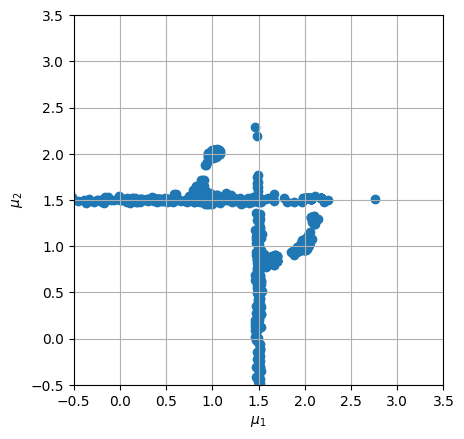

In [77]:
counts, bins = np.histogram(x, bins=32)
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_aspect("equal")
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([-0.5, 3.5])
ax.grid(True)
ax.set_xlabel(r"$\mu_1$")
ax.set_ylabel(r"$\mu_2$")
ax.scatter(mus_1, mus_2)
figure

In [78]:
samples_parameters = samples["parameters"].reshape((-1, 2 * k), order="F")
for key in samples.keys():
    print(key)

parameters
weights


(4096, 4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


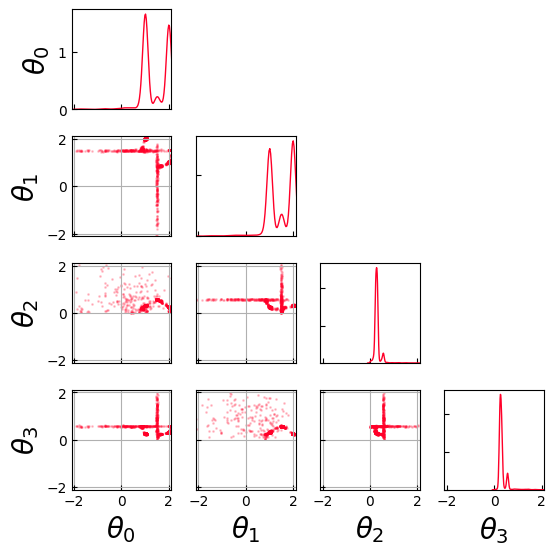

In [79]:
print(samples_parameters.shape)
figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(data_list=[samples_parameters])

In [80]:
sele_1 = np.argwhere((samples_parameters[:, 1] <= 1.5) * 1.0).squeeze()
sele_2 = np.argwhere((samples_parameters[:, 1] > 1.5) * 1.0).squeeze()
subset_1 = samples_parameters[sele_1]
subset_2 = samples_parameters[sele_2]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


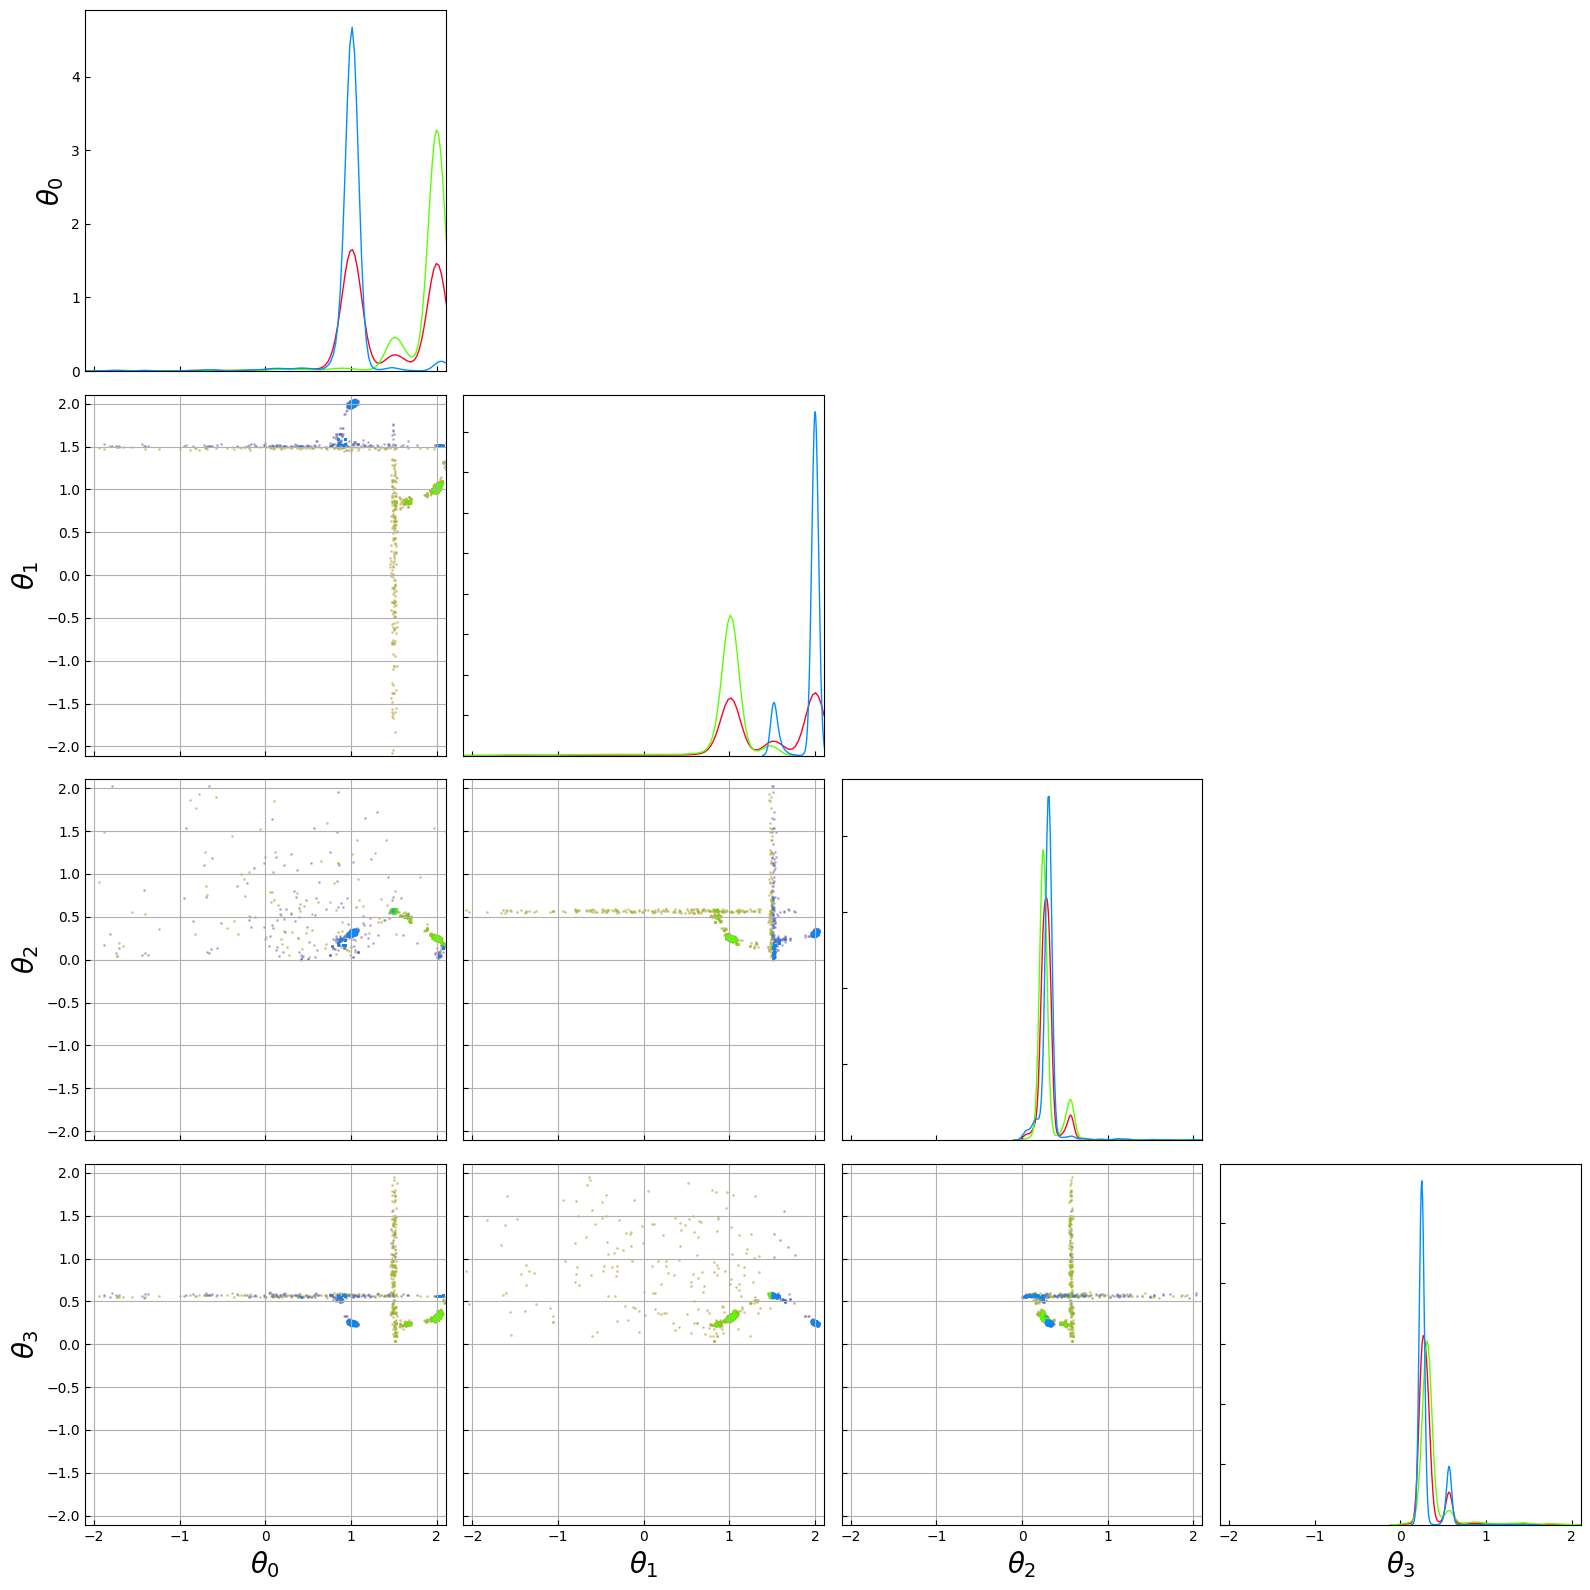

In [81]:
figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        ax_width=4.0,
        ax_height=4.0,
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(data_list=[samples_parameters, subset_1, subset_2])